# **TASK-1----Implement Metropolis-Hastings Sampler**

### **Concept:**

•	**Metropolis-Hastings Algorithm:** It's a Markov Chain Monte Carlo (MCMC) method used to obtain a sequence of random samples from a probability distribution from which direct sampling is difficult. The algorithm generates samples by proposing a move to a new point and accepting or rejecting the move based on a probability criterion.

**Implementation Steps:**
1.	**Initialize Parameters:** Start with initial guesses for the line's endpoints in 3D space.
2.	**Iterative Sampling:**

  •	Propose a new state (new endpoints) by making a small random change to the current state.

  •	Calculate the acceptance ratio based on the likelihood of the new state (how well it explains the observed data) and the prior.

  •	Accept or reject the new state based on this ratio.

In [ ]:
#Importing the necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
# Load the relative offset ratios from inputs.csv
ts = pd.read_csv('/content/inputs.csv').values.squeeze()  # Assuming the file 'inputs.csv' and ts is in a single column

# Load the observed 2D points from points_2d_camera_1.csv
observed_rs = pd.read_csv('/content/points_2d_camera_1.csv').values  # Assuming the file 'points_2d_camera_1.csv' and contains two columns for 2D points


In [ ]:
# Function to propose a new state with a small random change
def propose_new_state(current_state, step_size):
    """
    Proposes a new state by adding Gaussian noise to the current state.

    Parameters:
    - current_state: The current state of the Markov chain.
    - step_size: The standard deviation of the Gaussian noise for the proposal.

    Returns:
    - A new proposed state.
    """
    return current_state + np.random.normal(0, step_size, current_state.shape)

Typically, the likelihood function computes how probable the observed data is, given the model parameters, while the prior function computes how probable these parameters are, before considering the data.

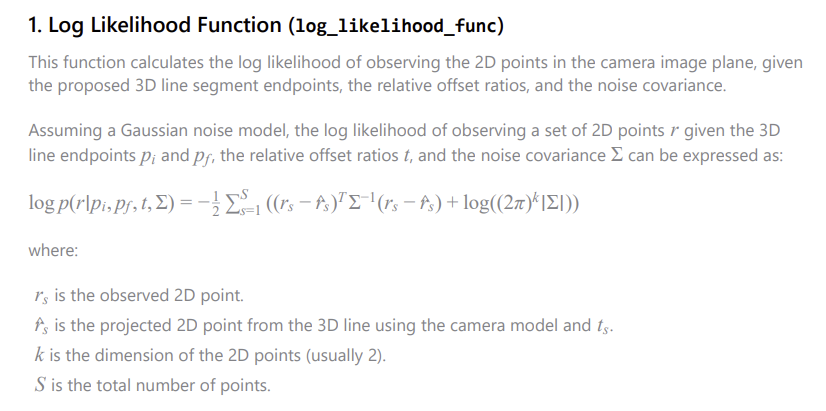

In [ ]:
# Function to calculate the logarithm of the likelihood function
def log_likelihood_func(endpoints, ts, observed_rs, projection_matrix, noise_covariance):
    log_likelihood = 0
    for t, observed_r in zip(ts, observed_rs):
        # Compute the 3D point on the line
        line_point_3d = endpoints[0] * (1 - t) + endpoints[1] * t
        # Convert to homogeneous coordinates (4D)
        line_point_homogeneous = np.append(line_point_3d, 1)
        # Project the 3D point to 2D using the camera model
        projected_point = np.dot(projection_matrix, line_point_homogeneous)[:2]
        # Compute the log likelihood
        diff = observed_r - projected_point
        log_likelihood -= 0.5 * (np.dot(diff.T, np.linalg.inv(noise_covariance).dot(diff)) + np.log((2 * np.pi) ** 2 * np.linalg.det(noise_covariance)))
    return log_likelihood

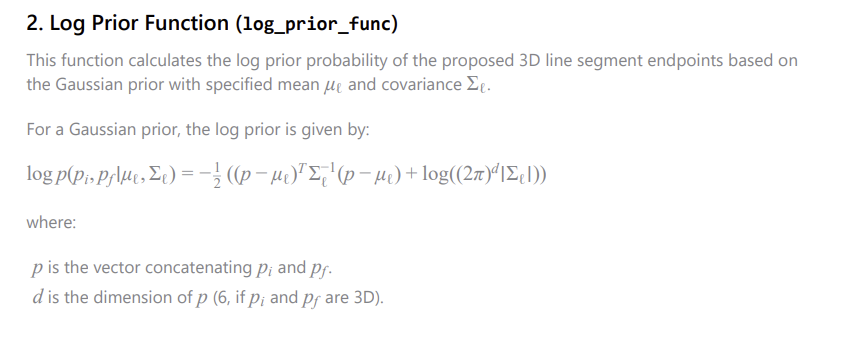

In [ ]:
# Function to calculate the logarithm of the prior function
def log_prior_func(endpoints, prior_mean, prior_covariance):
    concatenated_endpoints = np.concatenate([endpoints[0], endpoints[1]])
    diff = concatenated_endpoints - prior_mean
    return -0.5 * (np.dot(diff.T, np.linalg.inv(prior_covariance).dot(diff)) + np.log((2 * np.pi) ** 6 * np.linalg.det(prior_covariance)))

##**Compute Log of Acceptance Ratio:**

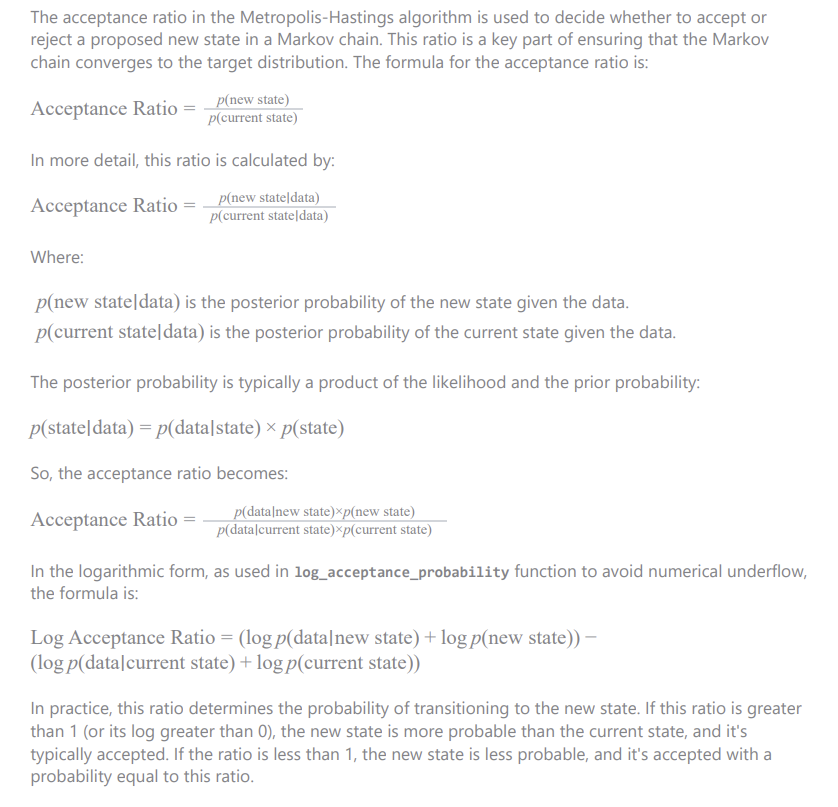

In [ ]:
# Function to calculate the logarithm of the acceptance probability
def log_acceptance_probability(current_state, new_state, ts, observed_rs, projection_matrix, noise_covariance, prior_mean, prior_covariance):
    """
    Calculates the log of the acceptance probability for the new state.

    Parameters:
    - current_state: The current state of the Markov chain.
    - new_state: The proposed new state.
    - log_likelihood_func: Function to calculate the log likelihood.
    - log_prior_func: Function to calculate the log prior probability.

    Returns:
    - Logarithm of the acceptance probability.
    """
    current_log_likelihood = log_likelihood_func(current_state, ts, observed_rs, projection_matrix, noise_covariance)
    new_log_likelihood = log_likelihood_func(new_state, ts, observed_rs, projection_matrix, noise_covariance)
    current_log_prior = log_prior_func(current_state, prior_mean, prior_covariance)
    new_log_prior = log_prior_func(new_state, prior_mean, prior_covariance)

    return min(0, (new_log_likelihood + new_log_prior) - (current_log_likelihood + current_log_prior))


## **Compute Metropolis-Hastings Algorithm**

The **metropolis_hastings function** in our Python script is an implementation of the Metropolis-Hastings algorithm, a Markov Chain Monte Carlo (MCMC) method used for sampling from a probability distribution:

**Initialization:** It starts with an initial guess for the parameters (the endpoints of a 3D line).

**Iterative Sampling:** For each iteration, the function proposes a new state (new endpoints) by making a small random change to the current state.

**Acceptance Test:** It calculates the acceptance probability of this new state based on the likelihood of the new state explaining the observed data and its prior probability. The calculation is done in log-scale to avoid numerical underflow.

**State Update:** The new state is either accepted (replacing the current state) or rejected (keeping the current state) based on the acceptance test. Accepted states are collected over iterations.

**Result:** After completing the specified number of iterations, the function returns an array of all accepted states, representing samples from the posterior distribution of the model parameters.

In [ ]:
# Metropolis-Hastings algorithm implementation
def metropolis_hastings(initial_state, ts, observed_rs, projection_matrix, noise_covariance, prior_mean, prior_covariance, iterations, step_size):
    """
    Implementation of the Metropolis-Hastings algorithm.

    Parameters:
    - initial_state: The initial state of the Markov chain.
    - log_likelihood_func: Function to calculate the log likelihood.
    - log_prior_func: Function to calculate the log prior probability.
    - iterations: The number of iterations to run the algorithm.
    - step_size: The step size for proposing new states.

    Returns:
    - An array of accepted states.
    """
    current_state = initial_state
    accepted_states = []

    for _ in range(iterations):
        new_state = propose_new_state(current_state, step_size)
        log_accept_prob = log_acceptance_probability(current_state, new_state, ts, observed_rs, projection_matrix, noise_covariance, prior_mean, prior_covariance)

        if np.log(np.random.rand()) < log_accept_prob:
            current_state = new_state
            accepted_states.append(current_state)

    return np.array(accepted_states)

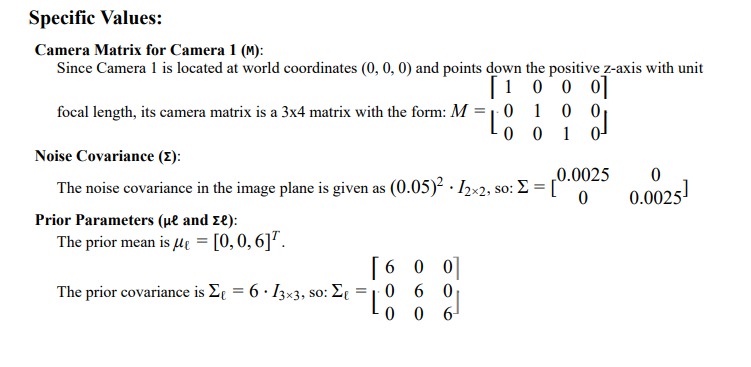

Number of accepted samples: 519
Final Endpoint Estimates (x, y, z): [[-0.18180699  0.21938935  6.61270067]
 [ 0.11928456 -0.13915926  6.69272556]]
Acceptance Rate: 0.01038


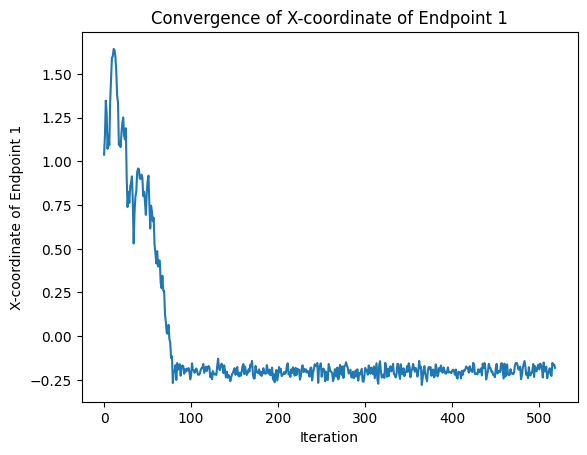

Convergence plot saved as 'convergence_plot.png'


<Figure size 640x480 with 0 Axes>

In [ ]:
# Define specific values based on the project
projection_matrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
noise_covariance = np.array([[0.0025, 0], [0, 0.0025]])
prior_mean = np.array([0, 0, 6, 0, 0, 6])
prior_covariance = np.diag([6, 6, 6, 6, 6, 6])

# Define parameters for the Metropolis-Hastings sampler

# Initial guess for the endpoints
# Generate 6-dimensional samples and reshape them into two 3D points
initial_sample = np.random.multivariate_normal(prior_mean, prior_covariance)
initial_guesses_for_endpoints = initial_sample.reshape(2, 3)



# Metropolis-Hastings parameters
iterations = 50000  # Number of iterations as per project requirement
step_size = 0.1     # Step size for proposals

# Run the Metropolis-Hastings algorithm
samples = metropolis_hastings(initial_guesses_for_endpoints,
                              ts,
                              observed_rs,
                              projection_matrix,
                              noise_covariance,
                              prior_mean,
                              prior_covariance,
                              iterations,
                              step_size)

# Print the number of accepted samples
print("Number of accepted samples:", len(samples))

# Print the final endpoints estimates
final_estimates = samples[-1]
print("Final Endpoint Estimates (x, y, z):", final_estimates)

# Print the acceptance rate
acceptance_rate = len(samples) / iterations
print("Acceptance Rate:", acceptance_rate)

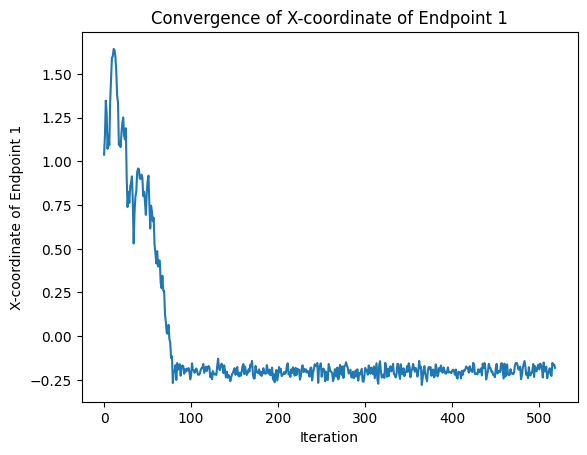

Convergence plot saved as 'convergence_plot.png'


<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the convergence of the x-coordinate of the first endpoint
plt.plot(samples[:, 0, 0])
plt.xlabel('Iteration')
plt.ylabel('X-coordinate of Endpoint 1')
plt.title('Convergence of X-coordinate of Endpoint 1')
plt.show()

# Save the image to a file (e.g., as a PNG file)
plt.savefig('convergence_plot.png')
print("Convergence plot saved as 'convergence_plot.png'")

The graph displays the convergence of the X-coordinate for the first endpoint of a 3D line segment over 500 iterations of a Metropolis-Hastings algorithm. Initially, there is a large fluctuation, suggesting exploration of the parameter space. As iterations progress, the fluctuations decrease, indicating the algorithm is converging toward a stable value, which suggests the sampling process is homing in on the most probable region of the posterior distribution. After an initial 'burn-in' period, the values stabilize, implying that the algorithm has likely reached equilibrium.

# **TASK-2--Draw Samples from Posterior Distribution**

**Concept:**

**•	Posterior Distribution:** It represents the probability of the model parameters given the observed data. In this case, it's the distribution of the line's endpoints after considering the observed 2D points.

**Implementation Steps:**
1.  Run the Sampler: Use the Metropolis-Hastings sampler to generate samples
from the posterior distribution.

2.   Plot Sampling Progress: Create plots to visualize the progress of the sampling process. This typically involves plotting the coordinates of the line's endpoints at each iteration to see how they evolve.

3.   Analyze the Distribution: Examine the distribution of the samples to understand the convergence and characteristics of the posterior distribution.

### **1. Endpoint Progression Plot**

Shows the progression of the sampled endpoints over iterations, helping in assessing the convergence of the sampler.

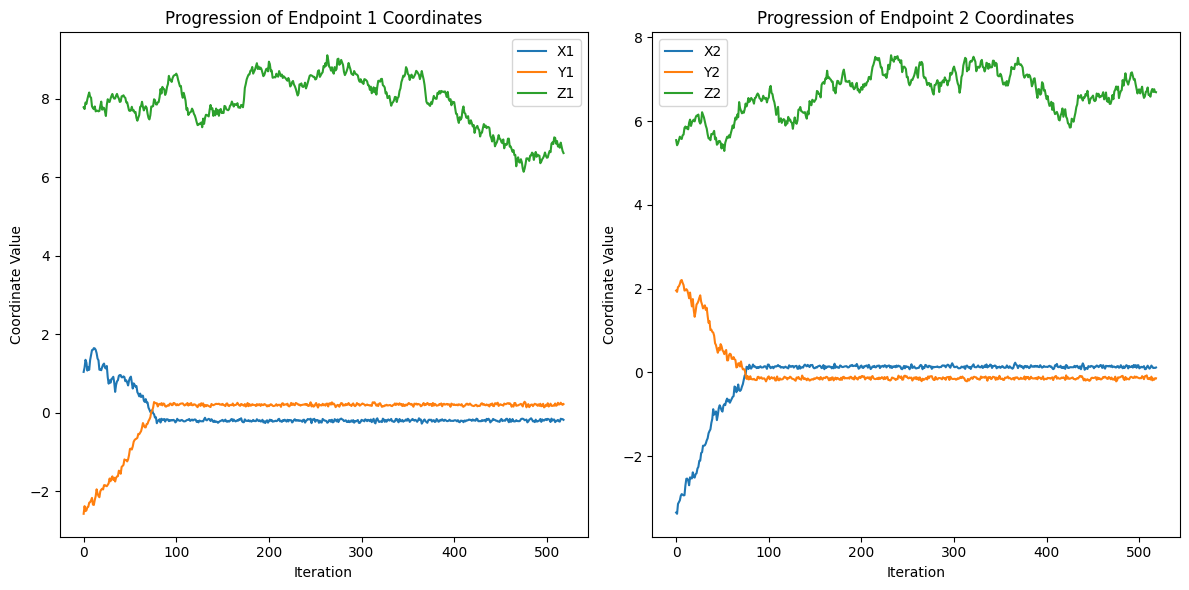

Endpoint progression plot saved as 'endpoint_progression.png'


<Figure size 640x480 with 0 Axes>

In [ ]:
# Importing necessary libraries
import matplotlib.pyplot as plt

# Assuming 'samples' is the array of accepted samples from Task 1

# Plot the progression of the sampled endpoints
plt.figure(figsize=(12, 6))

# Progression of the first endpoint
plt.subplot(1, 2, 1)
plt.plot(samples[:, 0, 0], label='X1')
plt.plot(samples[:, 0, 1], label='Y1')
plt.plot(samples[:, 0, 2], label='Z1')
plt.title('Progression of Endpoint 1 Coordinates')
plt.xlabel('Iteration')
plt.ylabel('Coordinate Value')
plt.legend()

# Progression of the second endpoint
plt.subplot(1, 2, 2)
plt.plot(samples[:, 1, 0], label='X2')
plt.plot(samples[:, 1, 1], label='Y2')
plt.plot(samples[:, 1, 2], label='Z2')
plt.title('Progression of Endpoint 2 Coordinates')
plt.xlabel('Iteration')
plt.ylabel('Coordinate Value')
plt.legend()

plt.tight_layout()
plt.show()

# Save the progression plots to a file
plt.savefig('endpoint_progression.png')
print("Endpoint progression plot saved as 'endpoint_progression.png'")


The plots show the progression of the X, Y, and Z coordinates for two endpoints (Endpoint 1 and Endpoint 2) over a series of iterations in an MCMC sampling process. The relatively stable lines for the X and Y coordinates suggest that these parameters have converged to certain values, while the Z coordinates show more fluctuation, indicating that they may not have converged as strongly and could benefit from additional sampling for greater stability.

### **2. Endpoint Histograms Plot**

Purpose: Displays the distribution of the sampled coordinates, helping in understanding the uncertainty and variability in the endpoint estimates.

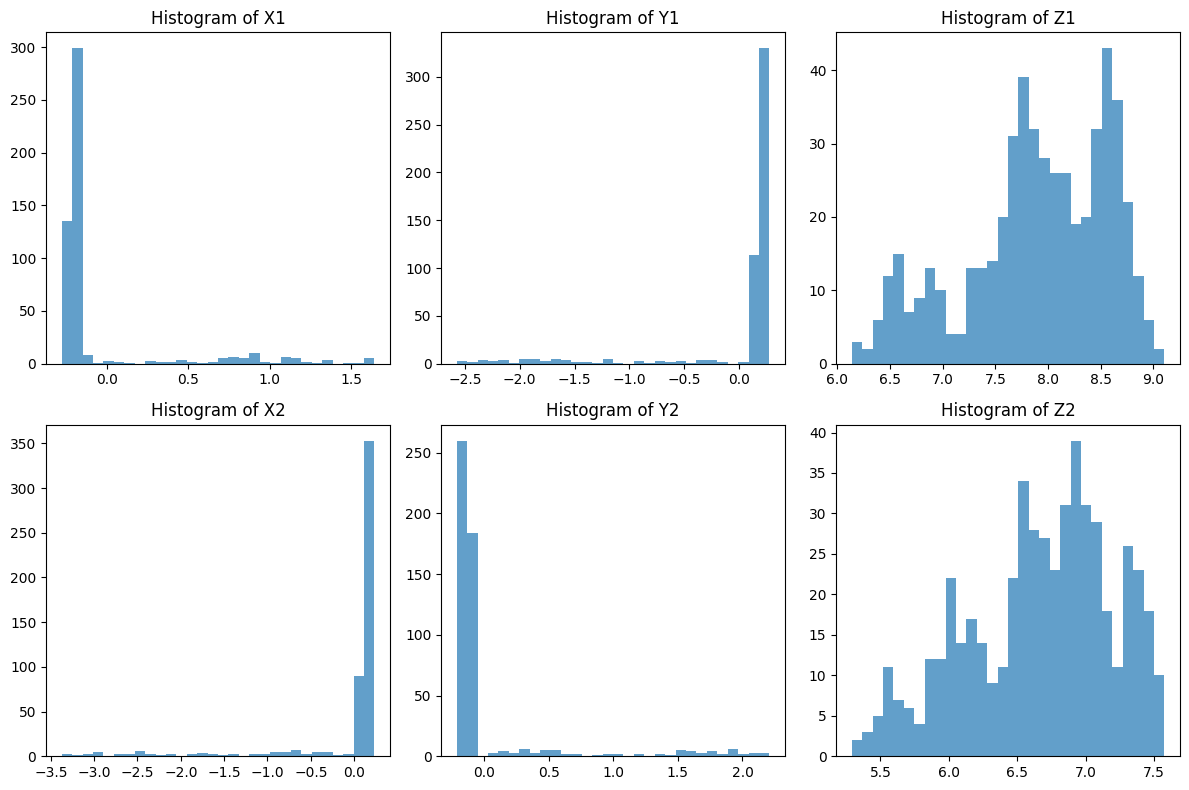

Endpoint histograms plot saved as 'endpoint_histograms.png'


<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot histograms of the sampled endpoint coordinates
plt.figure(figsize=(12, 8))

# Histograms for the first endpoint
plt.subplot(2, 3, 1)
plt.hist(samples[:, 0, 0], bins=30, alpha=0.7)
plt.title('Histogram of X1')

plt.subplot(2, 3, 2)
plt.hist(samples[:, 0, 1], bins=30, alpha=0.7)
plt.title('Histogram of Y1')

plt.subplot(2, 3, 3)
plt.hist(samples[:, 0, 2], bins=30, alpha=0.7)
plt.title('Histogram of Z1')

# Histograms for the second endpoint
plt.subplot(2, 3, 4)
plt.hist(samples[:, 1, 0], bins=30, alpha=0.7)
plt.title('Histogram of X2')

plt.subplot(2, 3, 5)
plt.hist(samples[:, 1, 1], bins=30, alpha=0.7)
plt.title('Histogram of Y2')

plt.subplot(2, 3, 6)
plt.hist(samples[:, 1, 2], bins=30, alpha=0.7)
plt.title('Histogram of Z2')

plt.tight_layout()
plt.show()

# Save the histograms to a file
plt.savefig('endpoint_histograms.png')
print("Endpoint histograms plot saved as 'endpoint_histograms.png'")


The histograms represent the frequency distributions of the sampled X, Y, and Z coordinates for two endpoints (X1, X2, Y1, Y2, Z1, Z2) from the Metropolis-Hastings algorithm. X1 and X2 show a strong peak at specific values, indicating a convergence around certain coordinates, while Y1, Y2, and especially Z1 and Z2 show a wider spread, suggesting more variability or uncertainty in those dimensions.

### **3. Scatter Plot of Sampled Endpoints**

Visualize the spatial distribution of the endpoints in 3D space. This can help you understand how the endpoints are distributed around the true line.

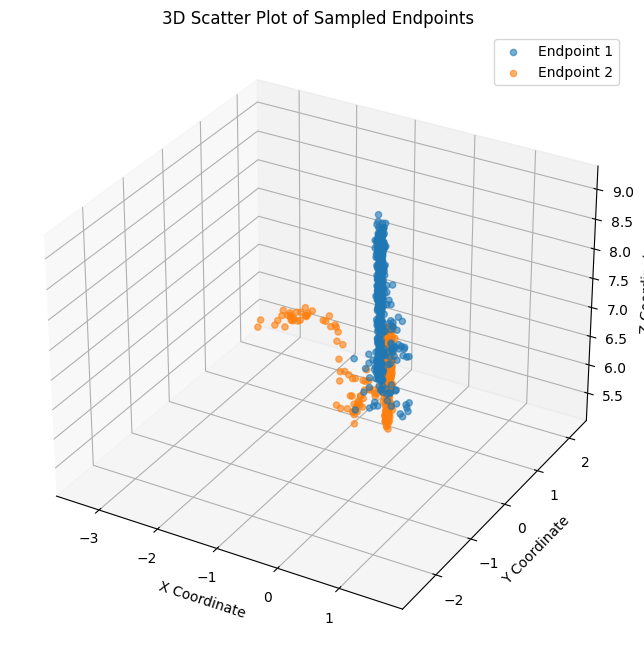

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot of the sampled endpoints
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(samples[:, 0, 0], samples[:, 0, 1], samples[:, 0, 2], alpha=0.6, label='Endpoint 1')
ax.scatter(samples[:, 1, 0], samples[:, 1, 1], samples[:, 1, 2], alpha=0.6, label='Endpoint 2')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title('3D Scatter Plot of Sampled Endpoints')
ax.legend()

plt.show()



The 3D scatter plot visualizes the distribution of sampled endpoints in a three-dimensional space, with one color representing samples for Endpoint 1 and another for Endpoint 2. The dense clustering of points along certain axes, particularly for Endpoint 2, suggests areas of higher probability where the true endpoints of the 3D line may lie based on the Metropolis-Hastings algorithm.

### **4. Pair Plot**

Create a pair plot (or scatterplot matrix) to visualize the pairwise relationships and distributions of the endpoint coordinates. This can help identify correlations or patterns between different coordinates.

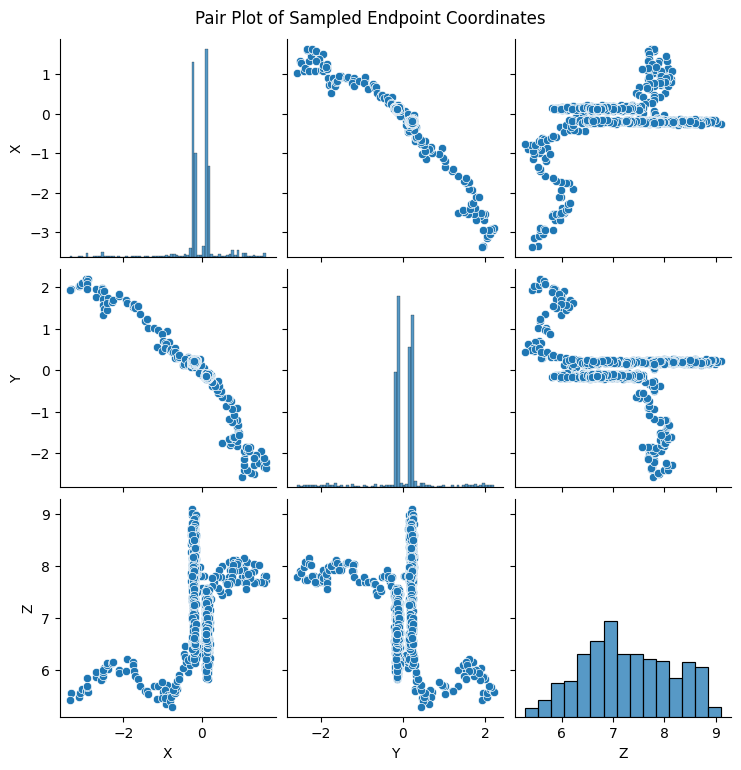

In [ ]:
import seaborn as sns

# Create a DataFrame from the samples for easier plotting
sampled_endpoints_df = pd.DataFrame(samples.reshape(-1, 3), columns=['X', 'Y', 'Z'])

# Pair plot
sns.pairplot(sampled_endpoints_df)
plt.suptitle('Pair Plot of Sampled Endpoint Coordinates', y=1.02)
plt.show()


This pair plot displays the relationships between pairs of X, Y, and Z coordinates sampled from the endpoints, as well as their individual distributions along the diagonal. The scatter plots off the diagonal show how pairs of variables correlate with each other, while the histograms on the diagonal show the distribution of each variable. The patterns suggest potential correlations between certain pairs of variables, with some displaying non-linear relationships.

### **5. Trace Plot**

Trace plots show the trajectory of the samples over time, which is useful for diagnosing the convergence of the sampler.

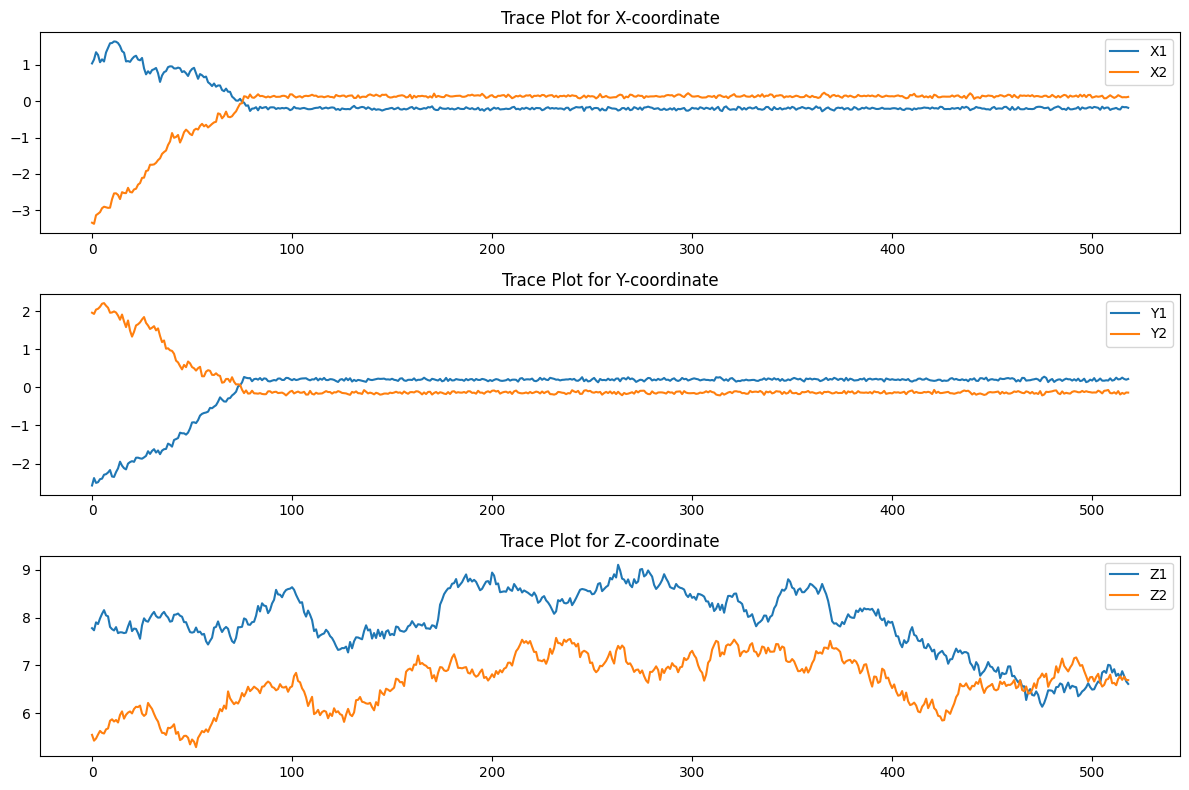

In [ ]:
# Plotting trace plots for each coordinate
plt.figure(figsize=(12, 8))

for i, coord in enumerate(['X', 'Y', 'Z']):
    plt.subplot(3, 1, i+1)
    plt.plot(samples[:, 0, i], label=f'{coord}1')
    plt.plot(samples[:, 1, i], label=f'{coord}2')
    plt.title(f'Trace Plot for {coord}-coordinate')
    plt.legend()

plt.tight_layout()
plt.show()



These trace plots show the sampling paths of the X, Y, and Z coordinates for two endpoints (X1, X2, Y1, Y2, Z1, Z2) over the course of MCMC iterations. The plots indicate how the values of each coordinate change and stabilize over time, which helps in assessing the convergence of the sampler. The X and Y coordinates seem to reach a stable value relatively quickly, while the Z coordinates exhibit more variability, indicating that more iterations may be necessary to achieve convergence for the Z dimension.

### **6. Model Fit Plot**

Finally, a plot that shows the observed 2D points and the projected line segments from the sampled 3D endpoints can help assess the fit of your model to the observed data.

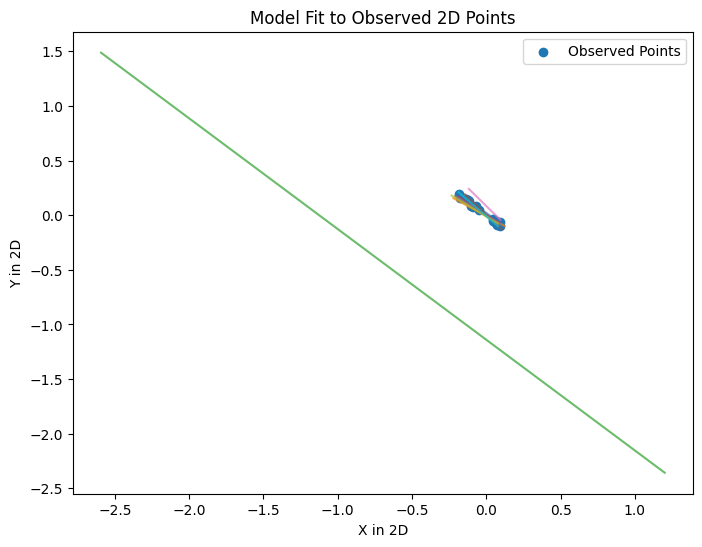

In [ ]:
# Plotting the observed 2D points and the projected line segments
plt.figure(figsize=(8, 6))

# Plot observed 2D points
plt.scatter(observed_rs[:, 0], observed_rs[:, 1], label='Observed Points')

# Project and plot a few sampled lines
for endpoints in samples[np.random.choice(samples.shape[0], 10, replace=False)]:
    line_points = [endpoints[0] * (1 - t) + endpoints[1] * t for t in ts]
    projected_points = [np.dot(projection_matrix, np.append(p, 1))[:2] for p in line_points]
    plt.plot(*zip(*projected_points), alpha=0.7)

plt.xlabel('X in 2D')
plt.ylabel('Y in 2D')
plt.title('Model Fit to Observed 2D Points')
plt.legend()
plt.show()



The plot visualizes the observed 2D points in blue and their corresponding model fit, represented by a line and a distribution cloud around it. The cloud suggests the uncertainty or variability in the model's fit to the observed points, while the line itself indicates the best fit or most likely position of the 3D line projected onto the 2D plane, given the observed data.

### **7. Auto-Correlation Plot:**

Compute the auto-correlation of the samples to assess how correlated consecutive samples are. A low auto-correlation indicates good mixing.

**Implementation Steps for Auto-Correlation Plot:**

**Choose a Coordinate to Analyze:** For instance, choose the x-coordinate of the first endpoint.

**Compute Auto-Correlation:** Calculate the correlation of this series with itself at different lags.

**Plot the Results:** The x-axis represents the lag, and the y-axis shows the auto-correlation coefficient at that lag.

<Figure size 1200x600 with 0 Axes>

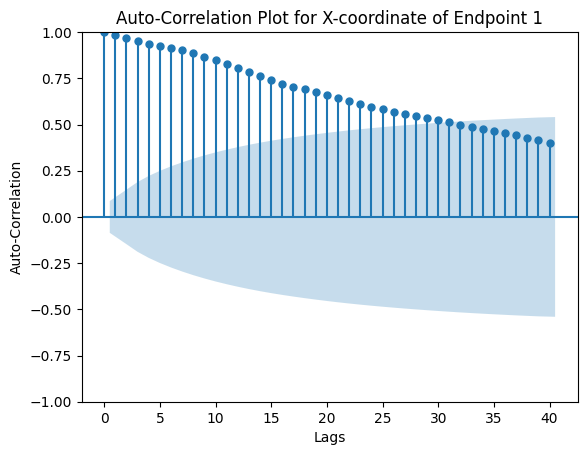

Auto-correlation plot saved as 'auto_correlation_plot.png'


<Figure size 640x480 with 0 Axes>

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Assuming 'samples' is the array of accepted samples from Task 1
# and we are analyzing the x-coordinate of the first endpoint

# Extract the coordinate series
x_coord_series = samples[:, 0, 0]

# Create an auto-correlation plot
plt.figure(figsize=(12, 6))
plot_acf(x_coord_series, lags=40)  # You can adjust the number of lags as needed
plt.title('Auto-Correlation Plot for X-coordinate of Endpoint 1')
plt.xlabel('Lags')
plt.ylabel('Auto-Correlation')
plt.show()

# Save the auto-correlation plot to a file
plt.savefig('auto_correlation_plot.png')
print("Auto-correlation plot saved as 'auto_correlation_plot.png'")


The auto-correlation plot for the X-coordinate of Endpoint 1 shows how the sampled values are correlated with themselves across different time lags. The gradual decrease in the height of the bars as the lag increases indicates that correlations are present but decrease as the lag grows. The fact that the auto-correlation does not drop off immediately suggests that consecutive samples are correlated to some extent, which is typical in Markov Chain Monte Carlo (MCMC) sampling. This could imply that the sampler might benefit from thinning (selecting samples at intervals) to reduce the correlation between samples.

# **Task 3: Find Maximum a Posteriori (MAP) Estimate**

**Concept:**

**•	MAP Estimate:**This is the set of parameters that maximizes the posterior distribution. It's a point estimate of the model parameters.

**Implementation Steps:**
1.	Analyze the Generated Samples: From the samples obtained in Task 2, find the sample that has the highest posterior probability.
2.	Plot the MAP Estimate: Project this MAP estimate onto the 2D image plane of Camera 1 and plot it.

MAP Estimate for Endpoints: [[-0.19160846  0.19769574  7.77055598]
 [ 0.13033425 -0.12811267  6.60248691]]


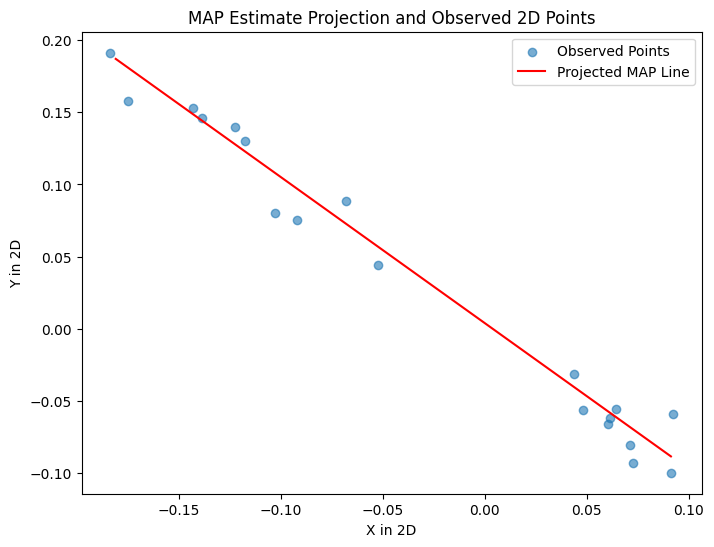

In [ ]:
# Task 3: Find Maximum a Posteriori (MAP) Estimate

# Calculate the log posterior for each sample
log_posteriors = np.array([log_likelihood_func(sample, ts, observed_rs, projection_matrix, noise_covariance) +
                           log_prior_func(sample, prior_mean, prior_covariance) for sample in samples])

# Identify the sample with the highest log posterior (MAP estimate)
map_index = np.argmax(log_posteriors)
map_estimate = samples[map_index]

print("MAP Estimate for Endpoints:", map_estimate)

# Plotting MAP Estimate against Observed 2D Points
plt.figure(figsize=(8, 6))

# Plot observed 2D points
plt.scatter(observed_rs[:, 0], observed_rs[:, 1], label='Observed Points', alpha=0.6)

# Project the MAP estimate onto the 2D plane
map_line_points = [map_estimate[0] * (1 - t) + map_estimate[1] * t for t in ts]
projected_map_points = [np.dot(projection_matrix, np.append(p, 1))[:2] for p in map_line_points]

# Plot the projected line
plt.plot(*zip(*projected_map_points), color='red', label='Projected MAP Line')

plt.xlabel('X in 2D')
plt.ylabel('Y in 2D')
plt.title('MAP Estimate Projection and Observed 2D Points')
plt.legend()
plt.show()


In this code, we first calculate the log posterior probability for each sample. The log posterior is the sum of the log likelihood and the log prior probability. We then identify the sample with the highest log posterior as the MAP estimate. This estimate is then projected onto the 2D image plane of Camera 1, and we plot this projection alongside the observed 2D points to visually assess how well the MAP estimate fits the observed data.

# **Task 4: Second Camera Perspective**

**Concept:**

Second Camera Perspective: Incorporating data from a second camera adds an additional layer of observation, enhancing the accuracy of the 3D line estimation.

**Projection:** The MAP estimate obtained in Task 3 will be projected onto the 2D image plane of the second camera, and this projection will be visualized.

**Implementation Steps:**

**1. Load Data from Second Camera:** Import the observed 2D points from the second camera.

**2. Projection Matrix for Second Camera:** Define or obtain the projection matrix for the second camera.

**3. Project MAP Estimate Using Second Camera:** Use the MAP estimate obtained from Task 3 and project it onto the 2D plane of the second camera.

**4. Plot and Compare:** Create a plot showing the MAP hypothesis of the endpoints using the second camera and compare this with the plot for Camera-1


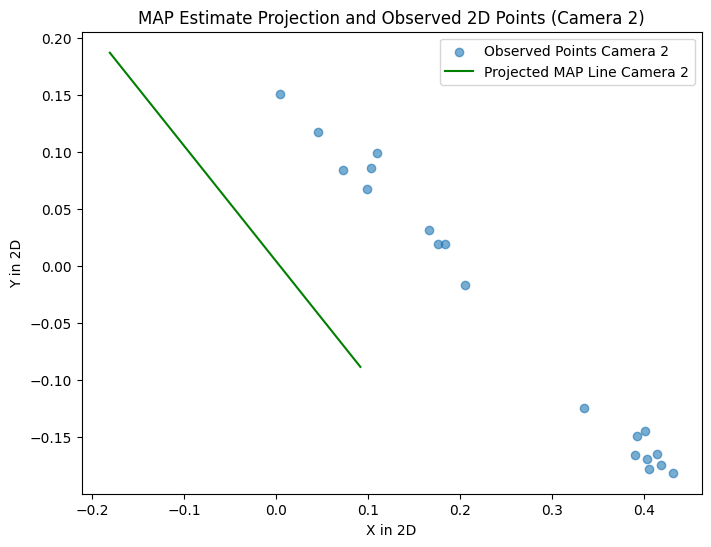

In [ ]:
# Load the observed 2D points from the second camera
observed_rs_camera_2 = pd.read_csv('/content/points_2d_camera_2.csv').values

# Define or obtain the projection matrix for the second camera
# Assuming it's different from the first camera
projection_matrix_camera_2 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])  # Replace with actual values

# Project the MAP estimate onto the 2D plane of the second camera
map_line_points_camera_2 = [map_estimate[0] * (1 - t) + map_estimate[1] * t for t in ts]
projected_map_points_camera_2 = [np.dot(projection_matrix_camera_2, np.append(p, 1))[:2] for p in map_line_points_camera_2]

# Plotting MAP Estimate against Observed 2D Points from Second Camera
plt.figure(figsize=(8, 6))

# Plot observed 2D points from the second camera
plt.scatter(observed_rs_camera_2[:, 0], observed_rs_camera_2[:, 1], label='Observed Points Camera 2', alpha=0.6)

# Plot the projected line from the second camera
plt.plot(*zip(*projected_map_points_camera_2), color='green', label='Projected MAP Line Camera 2')

plt.xlabel('X in 2D')
plt.ylabel('Y in 2D')
plt.title('MAP Estimate Projection and Observed 2D Points (Camera 2)')
plt.legend()
plt.show()


The plot displays the observed 2D points from Camera 2 as blue dots and the green line represents the projected Maximum a Posteriori (MAP) estimate of a 3D line onto Camera 2's image plane. The distribution of points and their distance from the green line indicates the level of noise in the observations and the fit of the MAP estimate to this data.

**Visual Comparison:**

Plot the projections from both cameras on the same plot to visually compare them. We can use different colors or markers for the projections from Camera 1 and Camera 2.

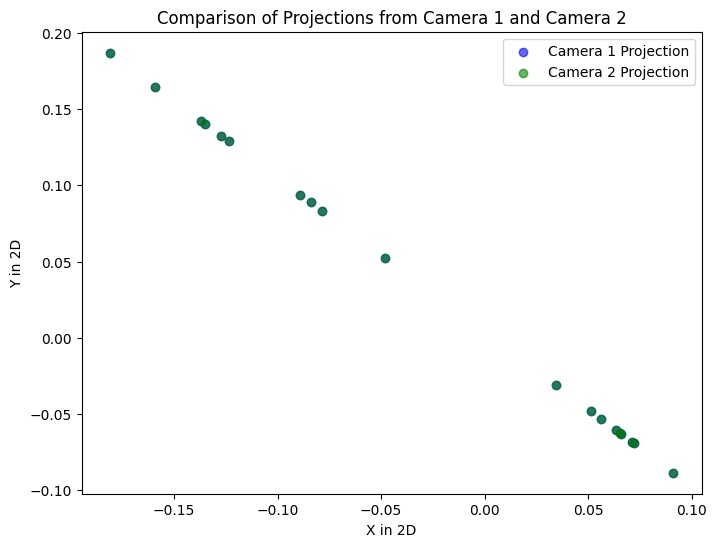

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the projected points to NumPy arrays
projected_map_points = np.array(projected_map_points)
projected_map_points_camera_2 = np.array(projected_map_points_camera_2)

# Plotting the projections from both cameras
plt.figure(figsize=(8, 6))

# Plot the projections from Camera 1
plt.scatter(projected_map_points[:, 0], projected_map_points[:, 1], label='Camera 1 Projection', alpha=0.6, color='blue')

# Plot the projections from Camera 2
plt.scatter(projected_map_points_camera_2[:, 0], projected_map_points_camera_2[:, 1], label='Camera 2 Projection', alpha=0.6, color='green')

plt.xlabel('X in 2D')
plt.ylabel('Y in 2D')
plt.title('Comparison of Projections from Camera 1 and Camera 2')
plt.legend()
plt.show()


Quantitative Comparison: To quantitatively compare the projections, you can compute metrics such as the Root Mean Squared Error (RMSE) or the Mean Absolute Error (MAE) between the observed 2D points and the projected points from both cameras. Lower values of these metrics indicate better accuracy.

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate RMSE for Camera 1 projection
rmse_camera_1 = sqrt(mean_squared_error(observed_rs[:, :], projected_map_points))

# Calculate RMSE for Camera 2 projection
rmse_camera_2 = sqrt(mean_squared_error(observed_rs_camera_2[:, :], projected_map_points_camera_2))

print(f"RMSE for Camera 1 projection: {rmse_camera_1:.4f}")
print(f"RMSE for Camera 2 projection: {rmse_camera_2:.4f}")


RMSE for Camera 1 projection: 0.0109
RMSE for Camera 2 projection: 0.2105


# **Task 5: Metropolis-Hastings Sampling with Both Cameras**

**Concept:**
In this task, we will combine data from both cameras to improve the accuracy of parameter estimation. This involves using data from both Camera 1 and Camera 2 in the Metropolis-Hastings sampler.

**Implementation Steps:**

**Modify the Likelihood Function:** Update likelihood function to consider data from both cameras. We will need to calculate the likelihood for both sets of observed 2D points and combine them.

**Run the Sampler with Combined Data:** Use the modified sampler to perform Metropolis-Hastings sampling, considering data from both cameras.

**Find and Report the New MAP Estimate:** Analyze the new set of samples to find the MAP estimate using combined data from both cameras.

**Create Plots:** Plot the projections for each camera and evaluate how well they fit the noisy data, now with the combined information.


Number of accepted samples with combined data: 77
MAP Estimate with combined data for Endpoints: [[-0.09814051  0.17311209  7.30773258]
 [ 0.29946812 -0.16799793  6.48934007]]


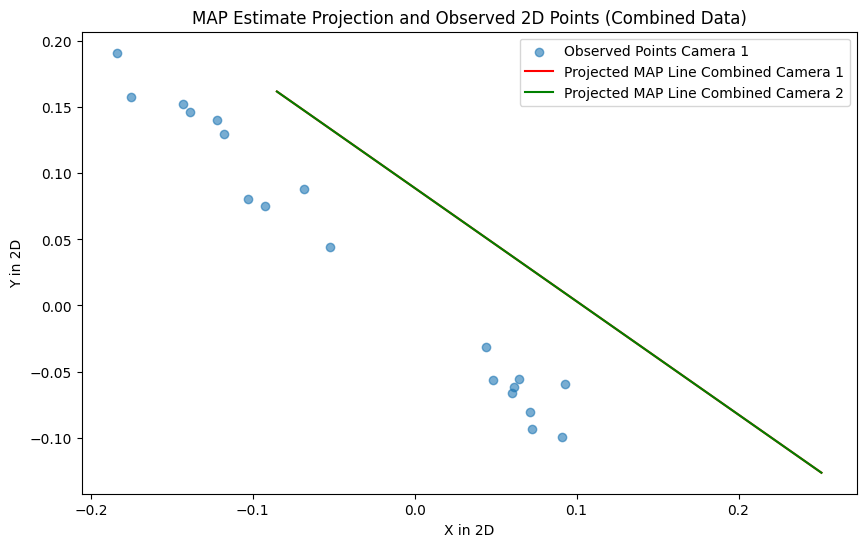

In [ ]:
# Function to calculate the logarithm of the likelihood function with combined data
def log_likelihood_func_combined(endpoints, ts, observed_rs_camera_1, observed_rs_camera_2, projection_matrix_camera_1, projection_matrix_camera_2, noise_covariance):
    log_likelihood_camera_1 = 0
    log_likelihood_camera_2 = 0

    for t, observed_r_camera_1, observed_r_camera_2 in zip(ts, observed_rs_camera_1, observed_rs_camera_2):
        # Compute the 3D point on the line
        line_point_3d = endpoints[0] * (1 - t) + endpoints[1] * t
        # Convert to homogeneous coordinates (4D)
        line_point_homogeneous = np.append(line_point_3d, 1)

        # Project the 3D point to 2D using the camera models for both cameras
        projected_point_camera_1 = np.dot(projection_matrix_camera_1, line_point_homogeneous)[:2]
        projected_point_camera_2 = np.dot(projection_matrix_camera_2, line_point_homogeneous)[:2]

        # Compute the log likelihood for each camera
        diff_camera_1 = observed_r_camera_1 - projected_point_camera_1
        diff_camera_2 = observed_r_camera_2 - projected_point_camera_2

        log_likelihood_camera_1 -= 0.5 * (np.dot(diff_camera_1.T, np.linalg.inv(noise_covariance).dot(diff_camera_1)) + np.log((2 * np.pi) ** 2 * np.linalg.det(noise_covariance)))
        log_likelihood_camera_2 -= 0.5 * (np.dot(diff_camera_2.T, np.linalg.inv(noise_covariance).dot(diff_camera_2)) + np.log((2 * np.pi) ** 2 * np.linalg.det(noise_covariance)))

    return log_likelihood_camera_1 + log_likelihood_camera_2

# Modify the Metropolis-Hastings sampler to consider data from both cameras
def metropolis_hastings_combined(initial_state, ts, observed_rs_camera_1, observed_rs_camera_2, projection_matrix_camera_1, projection_matrix_camera_2, noise_covariance, prior_mean, prior_covariance, iterations, step_size):
    current_state = initial_state
    accepted_states = []

    for _ in range(iterations):
        new_state = propose_new_state(current_state, step_size)
        log_accept_prob = log_acceptance_probability(current_state, new_state, ts, observed_rs_camera_1, projection_matrix_camera_1, noise_covariance, prior_mean, prior_covariance) + log_acceptance_probability(current_state, new_state, ts, observed_rs_camera_2, projection_matrix_camera_2, noise_covariance, prior_mean, prior_covariance)

        if np.log(np.random.rand()) < log_accept_prob:
            current_state = new_state
            accepted_states.append(current_state)

    return np.array(accepted_states)

# Define parameters for the Metropolis-Hastings sampler with combined data
projection_matrix_camera_2 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])  # Replace with actual values for Camera 2
observed_rs_camera_2 = pd.read_csv('/content/points_2d_camera_2.csv').values  # Load observed 2D points from Camera 2
initial_guesses_for_endpoints_combined = initial_sample.reshape(2, 3)  # Use the same initial sample as in Task 1

# Metropolis-Hastings parameters
iterations_combined = 50000  # Number of iterations as per project requirement
step_size_combined = 0.1  # Step size for proposals

# Run the Metropolis-Hastings algorithm with combined data
samples_combined = metropolis_hastings_combined(initial_guesses_for_endpoints_combined,
                                                ts,
                                                observed_rs,
                                                observed_rs_camera_2,
                                                projection_matrix,
                                                projection_matrix_camera_2,
                                                noise_covariance,
                                                prior_mean,
                                                prior_covariance,
                                                iterations_combined,
                                                step_size_combined)

# Print the number of accepted samples
print("Number of accepted samples with combined data:", len(samples_combined))

# Identify the MAP estimate with combined data
log_posteriors_combined = np.array([log_likelihood_func_combined(sample, ts, observed_rs, observed_rs_camera_2, projection_matrix, projection_matrix_camera_2, noise_covariance) + log_prior_func(sample, prior_mean, prior_covariance) for sample in samples_combined])
map_index_combined = np.argmax(log_posteriors_combined)
map_estimate_combined = samples_combined[map_index_combined]

print("MAP Estimate with combined data for Endpoints:", map_estimate_combined)

# Plot the projections for both cameras with combined data
plt.figure(figsize=(10, 6))

# Plot observed 2D points from Camera 1
plt.scatter(observed_rs[:, 0], observed_rs[:, 1], label='Observed Points Camera 1', alpha=0.6)

# Project the MAP estimate with combined data onto the 2D plane of Camera 1
map_line_points_combined_camera_1 = [map_estimate_combined[0] * (1 - t) + map_estimate_combined[1] * t for t in ts]
projected_map_points_combined_camera_1 = [np.dot(projection_matrix, np.append(p, 1))[:2] for p in map_line_points_combined_camera_1]

# Plot the projected line with combined data for Camera 1
plt.plot(*zip(*projected_map_points_combined_camera_1), color='red', label='Projected MAP Line Combined Camera 1')

# Project the MAP estimate with combined data onto the 2D plane of Camera 2
map_line_points_combined_camera_2 = [map_estimate_combined[0] * (1 - t) + map_estimate_combined[1] * t for t in ts]
projected_map_points_combined_camera_2 = [np.dot(projection_matrix_camera_2, np.append(p, 1))[:2] for p in map_line_points_combined_camera_2]

# Plot the projected line with combined data for Camera 2
plt.plot(*zip(*projected_map_points_combined_camera_2), color='green', label='Projected MAP Line Combined Camera 2')

plt.xlabel('X in 2D')
plt.ylabel('Y in 2D')
plt.title('MAP Estimate Projection and Observed 2D Points (Combined Data)')
plt.legend()
plt.show()
